Note that there is approximately around 15808 - 14563  = 1200 rows that have nan values that are incorrect.

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats
import math
import random
from scipy.stats import binom_test
from scipy.stats import kstest
from scipy.stats import norm
import sys 
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import poisson

import numpy as np
from numpy.random import random

In [5]:
def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

In [6]:
class Model:
    def __init__(self):
        self.df = self.readindata() # processes our data into one dataframe
        self.cumprobdf = self.generatecumdata() # generates a cumulative probability dataframe
        self.binomialestimates = self.generatefinalbinomest() # returns final binomial estimates given observed all the data

    def readindata(self):
        df1 = pd.read_csv('combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link','a1','a2','a3','a4','a5','a6','a7','a8','a9','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20','a21','a22','a23','a24','Date','a26'])
        df1 = df1.dropna(subset = 'Date')
        df2 = pd.read_csv('set2_combined.csv', sep = ';', header = None,on_bad_lines='skip',names = ['Link','b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','Date','b26'])
        df2 = df2.dropna(subset = 'Date')

        #Perform outer join
        df = pd.merge(df1,df2,how = 'outer')
        df['Date'] = [elem.split(sep='T')[0] for elem in df['Date']]
        df['Date'] = [datetime.strptime(elem,"%Y-%m-%d") for elem in df['Date']]
        #Convert date format

        #Create a counter of the number of articles so when resampling, we attain the number of articles per day
        df['NumOfArticles'] = [1 for i in range(len(df['Date']))]

        #Drop columns a26 and b26 and the list of links
        del df['a26']
        del df['b26']
        del df['Link']

        #Set index to equal date and get rid of that column
        df.index = df['Date']
        del df['Date']

        #For each row, if the element appears in the article set equal to 1 else 0
        for column in list(df):
            df[column] = [1 if elem>0 else 0 for elem in df[column]]

        #Group by day
        df = df.resample('D').sum()

        #Select start and end dates
        df =df.loc['2022-02-02':'2023-2-10']
        print("Process our DataFrame:                   Successfully parsed and formatted our data")
        return(df) # returns processed dataframe

    def generatecumdata(self):
        #Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
        cumprob = self.df.copy()

        #Generates cumulative sum
        for column in list(cumprob)[:-1]:
            cumprob[column] = [sum(cumprob[column][:i+1])/sum(cumprob['NumOfArticles'][:i+1]) for i in range(0,len(cumprob[column]))]
        cumprob['NumOfArticles'] =np.cumsum(cumprob['NumOfArticles'])

        #Compute Binomial Estimates
        binomestimates = [sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]]

        #Check that estimates line up with cumulative probaiblities at the end of the dataframe
        for i in range(0,len(cumprob.iloc[-1][:-1])):
            if (cumprob.iloc[-1][:-1][i] != binomestimates[i]):
                print(False)
                break
            if i == len(cumprob.iloc[-1][:-1])-1:
                print("""Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities""")
                #If test completes successfully
        return(cumprob) # returns a dataframe containing cumulative probabilities
        
    def generatefinalbinomest(self):
        return([sum(self.df[column])/sum(self.df['NumOfArticles']) for column in list(self.df)[:-1]])
    
    def MA_mean_df(self,K):
        #Generate moving average of observations
        movingaveragedf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center = True)).mean()

    def MA_sd_df(self,K):
        #Generate moving average of standard deviations
        movingsddf = self.df.copy()
        return(pd.DataFrame(self.df).rolling(K,center=True).std())

    def MA_binomest_CI_plot(self,column= None, K=30,alpha=0.05):
        #Generates plot for a given column
        rollingbinomestimatesdf = self.cumprobdf

        rolling_binom_estimate = list(rollingbinomestimatesdf[column])

        CI_lower = []
        CI_upper = []

        for k in range(len(rolling_binom_estimate)):
            total = list(self.cumprobdf['NumOfArticles'])[k]
            successes = total*rolling_binom_estimate[k]
            lo, hi = clopper_pearson(successes, total)
            CI_lower.append(lo)
            CI_upper.append(hi)
        
        figure(figsize=(10, 10), dpi=160)
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        #Plot binomestiamtes
        ax1.plot(self.df.index.values, rolling_binom_estimate, label = "line 1")
        #Plot upper and lower CI
        ax1.plot(self.df.index.values,CI_lower , label = "line 2")
        ax1.plot(self.df.index.values,CI_upper , label = "line 3")
        #Plot mean of our data
        ax2.bar(self.df.index.values, self.MA_mean_df(30)[column] ,width = 0.3)
        plt.show()
    
    def CI_of_estimates_plot(self):
        lot = []
        hit = []
        # For each of the final binomial estimates
        for prob in self.binomialestimates:
            successes = prob*self.cumprobdf['NumOfArticles'][-1]
            total = self.cumprobdf['NumOfArticles'][-1]
            lo, hi = clopper_pearson(successes, total)
            lot.append(lo)
            hit.append(hi)

        y=[]
        for i in range(len(self.binomialestimates)):
            y.append((lot[i],hit[i]))
        x = [i for i in range(len(self.binomialestimates))]
        plt.scatter(x,self.binomialestimates, s = 4)
        plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
        plt.xlabel("Category")
        plt.ylabel('Probability')
        plt.show()
        #remember to define p first!

    #remember to define p first!

    def binplot2(self):
        columns = list(self.df)[0:-1]
        k = 0 
        column = columns
        for column in columns:
            #Set up plots with two axis
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            #Compute histogram with weights i.e. the pdf
            #weights = np.ones_like(self.df[column]) / list(self.cumprobdf["NumOfArticles"])[-1]
            labels, counts = np.unique(self.df[column], return_counts=True)
            counts = counts/list(self.cumprobdf["NumOfArticles"])[-1]
            ax1.bar(labels, counts, align='center',width = 0.4,alpha = 0.7)
            #ax1.gca().set_xticks(labels)
            #ax1.hist(self.df[column], weights=weights, align = 'center')

            #Compute the binomial pdf
            p_hat = np.mean(self.df[column])/list(self.df["NumOfArticles"])[-1]
            # n is fixed
            n = list(self.df["NumOfArticles"])[-1]
            # defining list of r values
            r_values = list(range(0,max(self.df[column])+1))
            # list of pmf values
            dist = [binom.pmf(r, n, p_hat) for r in r_values ]
            # plotting the graphs
            ax2.plot(r_values, dist,"r-")
            
            ax1.set_title(column)
            ax1.set_ylabel("Histogram Density")
            ax2.set_ylabel("Probability Density")
            ax1_ylims = ax1.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax1_yratio = ax1_ylims[0] / ax1_ylims[1]  # Calculate ratio of lowest limit to highest limit

            ax2_ylims = ax2.axes.get_ylim()           # Find y-axis limits set by the plotter
            ax2_yratio = ax2_ylims[0] / ax2_ylims[1]  # Calculate ratio of lowest limit to highest limit


            # If the plot limits ratio of plot 1 is smaller than plot 2, the first data set has
            # a wider range range than the second data set. Calculate a new low limit for the
            # second data set to obtain a similar ratio to the first data set.
            # Else, do it the other way around

            if ax1_yratio < ax2_yratio: 
                ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
            else:
                ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

            plt.tight_layout()
            plt.show()
                  
    

In [55]:
class MonteCarlo:
    def __init__(self,df):
        self.hi = 2
        self.df = df

    # state space model - Mutation
    def StateSpace_iplus1(self,xt):
        return(xt*np.random.uniform(low = 0.8, high = 1.2))
        #return(Xt_1 *dnp.random.lognormal(mean=0.0, sigma=1.0)
        #return(Xt_1*np.random.exponential(scale = 1))
    
    #Mutation
    def hiddenmodel_iplus1(self,observation,state):
        return(poisson.pmf(observation, mu=state))

    def general_filter(self,obs,N):
        # N is the number of particles for filter
        # oba is our observation vector
        obs = np.array(obs)

        # Initial prior distribution for our unobservable quantity of interest
        initialstate = [np.mean(obs) for i in range(0,N)]
        X = initialstate
        #Store the final rate paramater
        rate =np.zeros(len(obs))

        for i in range(0,len(obs)):
            #Give the parameter for our state space model and updated rate 
            # having ovserved our data point Y[i]
            [X,X_est] = self.Filter(X,obs[i],N)
            rate[i] = X_est
        return(rate)

    def Filter(self,Particles,Yobs,N):
        Weights = [0 for i in range(N)]
        
        #For each particle in our filter

        #Draw a sample for our 'proposal distribution' i.e. for computing predictive step
        for i in range(0,N):
            #Mutate firstly
            
            Particles[i] = self.StateSpace_iplus1(Particles[i])
            #Compute weights by computing the current likelihood of a particle
            Weights[i] = self.hiddenmodel_iplus1(Yobs,Particles[i])

        #Normalise weights
        sumW = sum(Weights)
        for i in range(N):
            Weights[i] = Weights[i]/sumW
            
        #Resample from these weights    

        Particles = np.random.choice(Particles,replace = True, size = N, p = Weights)
        
        #Convert to state space vectors
        Particles_est = sum(Particles)/N
        return(Particles,Particles_est)    

    def movingaveragemontecarlo(self,ID,K,N):
        p_est_dict = {}
        #changed plot to normal data
        vals = self.df[ID]
        df_dummy = self.df.copy()
        # p_est_array = np.array(Ksum(vals,K))/K
        rate = self.general_filter(self.df[ID],N)
        
        #dfp.rolling(7, center=True).mean()
        hi = pd.DataFrame(vals)
        dude = pd.DataFrame(hi).rolling(K, center=True).mean()
        p_est_dict[ID] = dude[ID]
        p_est_array = dude[ID]
        
        hi = pd.DataFrame(self.df[ID])
        dude = pd.DataFrame(hi).rolling(K, center=True).mean()
        #return(d
        
        
        df_dummy['Plottingrate'] = rate
        
        figure(figsize=(10, 20), dpi=320)
        fig, ax = plt.subplots()
        #ax1.plot(df.index.values,df_dummy['Plottingrate'], color = 'red')
        #ax1.set_ylabel('SMC')
        
        #ax2 = ax1.twinx()
        #ax2.bar(df.index.values, dude[ID] ,width = 0.3)
        #ax2.set_ylabel('Moving Average')
        
        plt.plot(self.df.index.values,df_dummy['Plottingrate'], color = 'red')
        ax.bar(self.df.index.values, dude[ID] ,width = 0.3)
        
        #Ksum(df[ID].values,30)
        #
        #plt.plot(d0f.index.values, cumdata[ID])
        # ax1.plot(df.index.values,df_dummy['Plottingrate'], "r-")
        # ax1.ylabel('SMC')
        plt.title(ID)
        plt.show()
        #plt.savefig('new ' +ID+'.png')


In [43]:
analysis = Model()
df = analysis.df
#analysis.MA_binomest_CI_plot('a5')
#analysis.CI_of_estimates_plot()
#analysis.binplot2()

Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


Process our DataFrame:                   Successfully parsed and formatted our data
Process our Cumulative Probabilities DataFrame:     TEST-
                    Binomial Probabilities is the same as last row of cumulative probabilities


<Figure size 3200x6400 with 0 Axes>

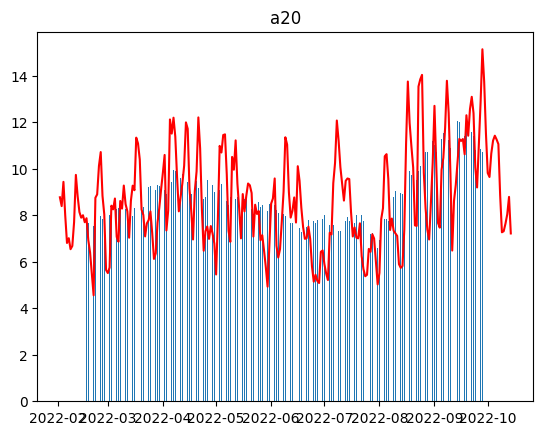

In [59]:
analysis = Model()
filter = MonteCarlo(analysis.df)
filter.movingaveragemontecarlo('a20',30,100)

In [36]:
def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

from FunctionFile import * 

In [205]:
#Create a dataframe that computes the cumulative probability up until that date of a keyword occuring
cumprob = df.copy()

for column in list(cumprob)[:-1]:
    cumprob[column] = [sum(cumprob[column][:i+1])/sum(cumprob['NumOfArticles'][:i+1]) for i in range(0,len(cumprob[column]))]
cumprob['NumOfArticles'] =np.cumsum(cumprob['NumOfArticles'])

#Compute Binomial Estimates
binomestimates = [sum(df[column])/sum(df['NumOfArticles']) for column in list(df)[:-1]]

#Check that estimates line up with cumulative probaiblities at the end of the dataframe
for i in range(0,len(cumprob.iloc[-1][:-1])):
    if (cumprob.iloc[-1][:-1][i] != binomestimates[i]):
        print(False)
        break
    if i == len(cumprob.iloc[-1][:-1])-1:
        print("Binomial Probabilities is the same as last row of cumulative probabilities")
    

#TEST is valid.


Binomial Probabilities is the same as last row of cumulative probabilities


<Figure size 1600x1600 with 0 Axes>

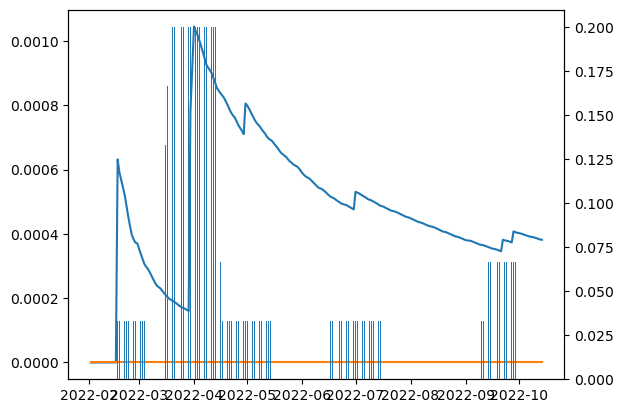

In [239]:
movingaverage(data, 'd5', 30, 0.05)

In [240]:
cols = list(cumprobdata)
cols = cols[1:-1]
cols
p = []
for ID in cols:
    p.append(cumprobdata.tail(1)[ID])

In [241]:
lot = []
hit = []
for i in p:
    successes = i*len(cumprobdata)
    total = len(cumprobdata)
    lo, hi = clopper_pearson(successes, total)
    lot.append(lo[0])
    hit.append(hi[0])
y=[]
for i in range(len(p)):
    y.append((lot[i],hit[i]))
x = [i for i in range(len(cols))]
plt.scatter(x,p, s = 10)
plt.plot((x,x),([i for (i,j) in y], [j for (i,j) in y]),c='black')
plt.show()
#remember to define p first!

def binplot(df):
    cols = list(df)[0:-1]
    hi = []
    k = 0 
    for ID in cols: 
        hi.append(kstest(df[ID], 'norm'))
        myarray = df[ID]
        weights = np.ones_like(myarray) / len(myarray)
        plt.hist(myarray, weights=weights)

        n = len(data)
        # defining list of r values
        r_values = list(range(0,30))
        # list of pmf values
        dist = [binom.pmf(r, n, p[k]) for r in r_values ]
        # plotting the graphs
        fg = Figure()
        ax = fg.gca()
        plt.plot(r_values, dist)
        plt.ylabel(ID)
        plt.xlabel(str(p[k]*len(data)))
        print(p[k])
        plt.show()
        k+=1
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return(hi)

In [246]:
#remember to define p first!

def binplot2(df):
    cols = list(df)[0:-1]
    hi = []
    k = 0 
    for ID in cols: 
        hi.append(kstest(df[ID], 'norm'))
        myarray = df[ID]
        weights = np.ones_like(myarray) / len(myarray)
        plt.hist(myarray, weights=weights)
        p_hat = np.mean(myarray)/len(myarray)
        n = len(data)
        # defining list of r values
        r_values = list(range(0,30))
        # list of pmf values
        dist = [binom.pmf(r, n, p_hat) for r in r_values ]
        # plotting the graphs
        fig, ax = plt.subplots()
        plt.plot(r_values, dist)
        plt.ylabel(ID)
       # plt.xlabel(str(p[k]*len(data)))#list index out of range!!!
        #print(p[k])
        k+=1
        plt.savefig("hist" + ID+'.png')
    return(hi)

C:\Users\kianv\AppData\Local\Temp\ipykernel_18556\2860582045.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


[KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=0.5, pvalue=1.7858898822804354e-59),
 KstestResult(statistic=

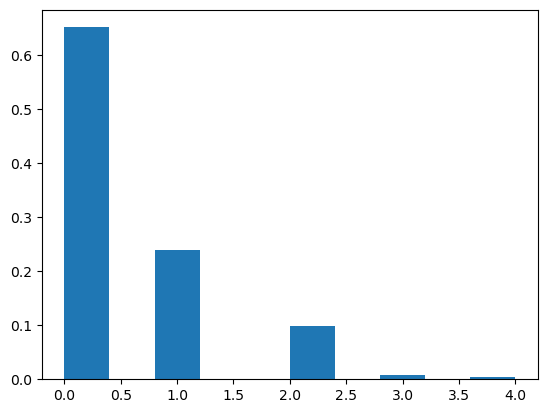

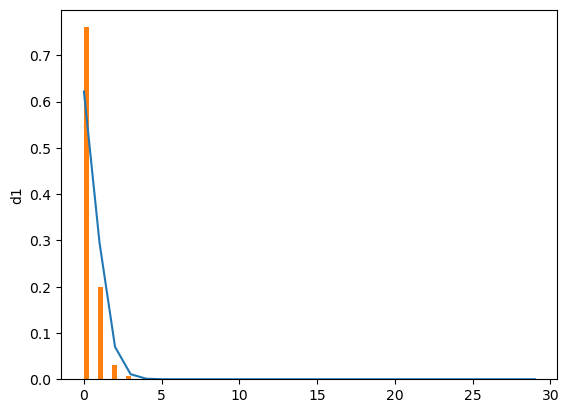

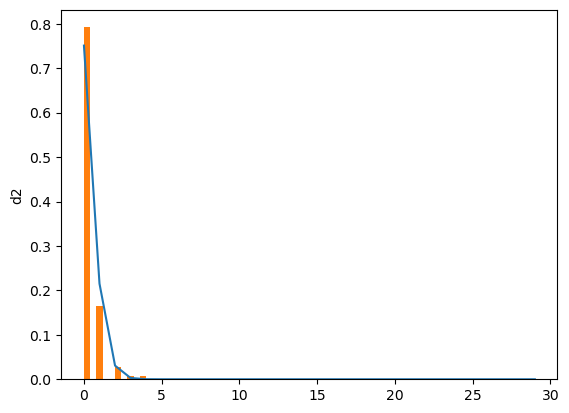

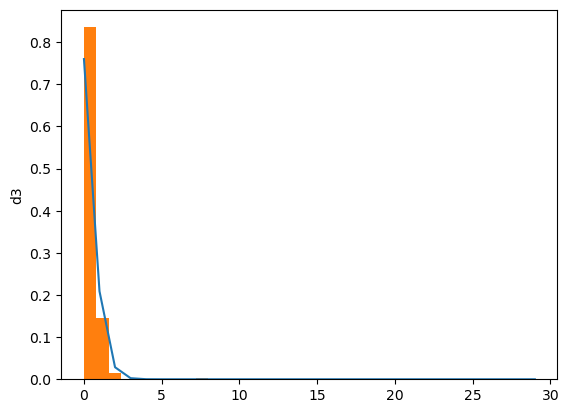

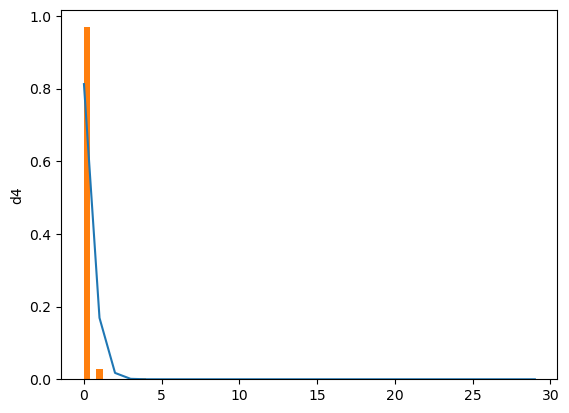

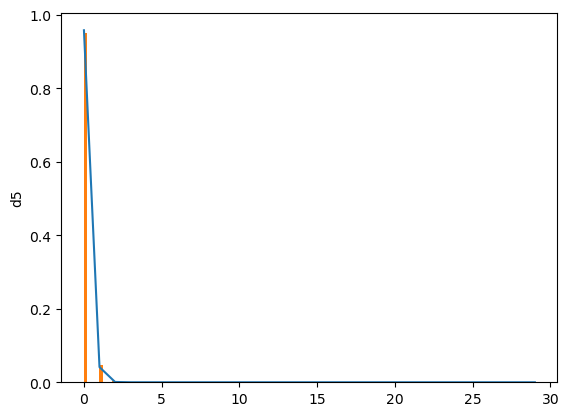

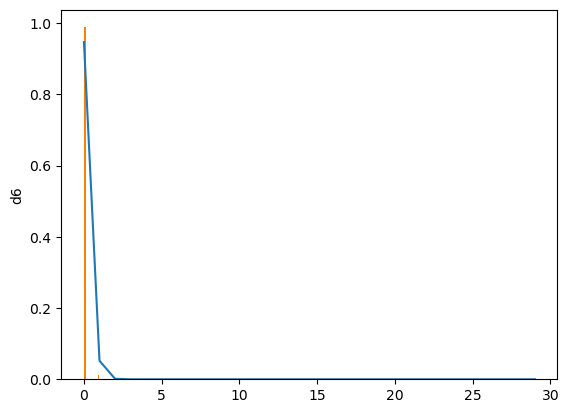

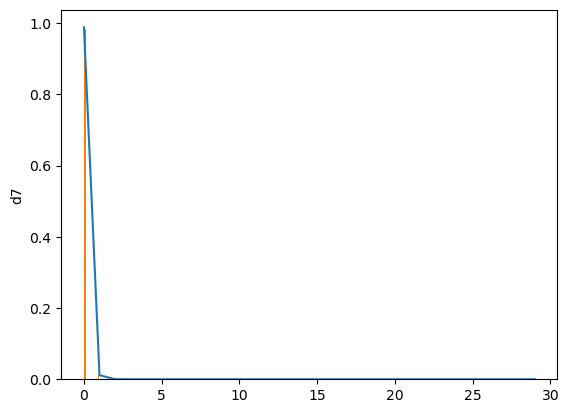

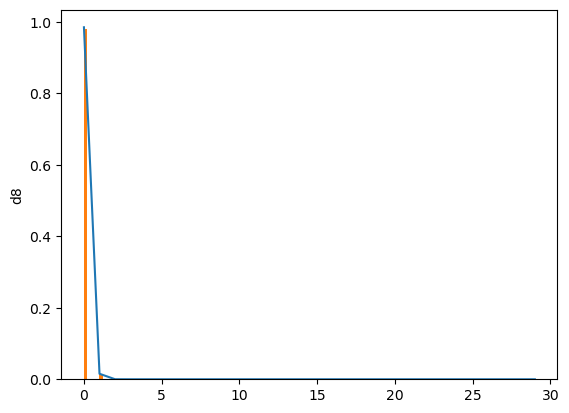

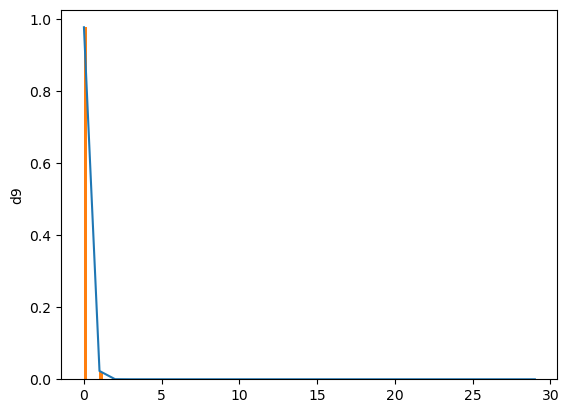

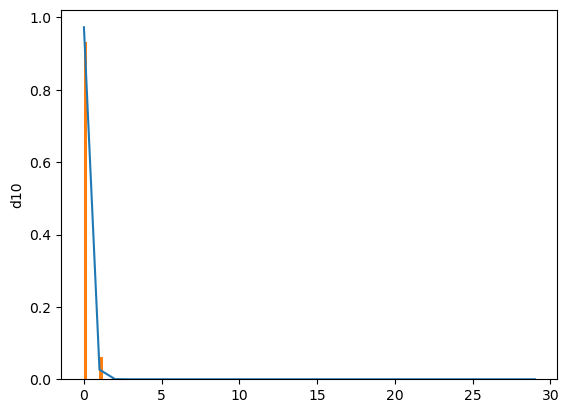

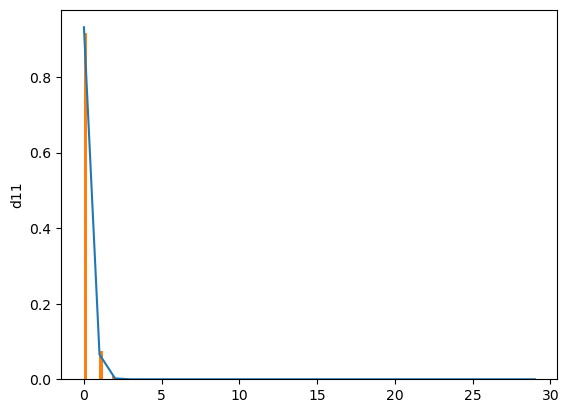

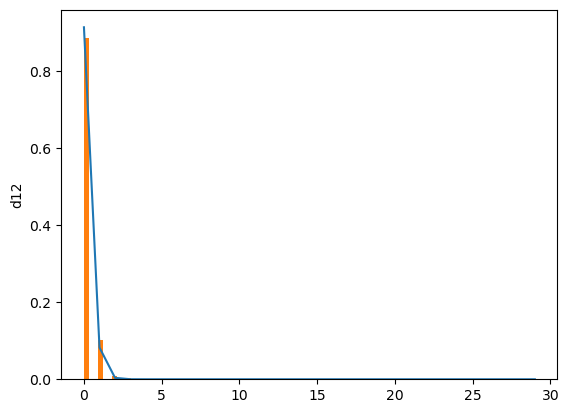

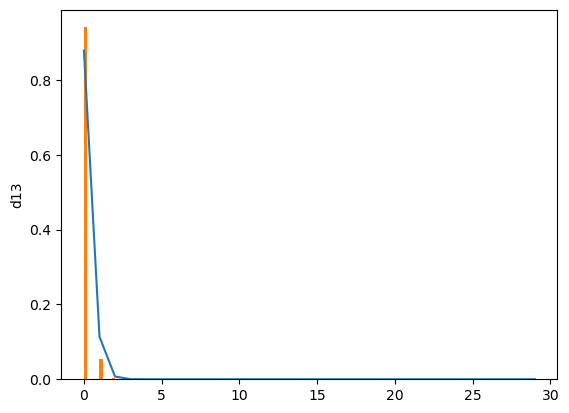

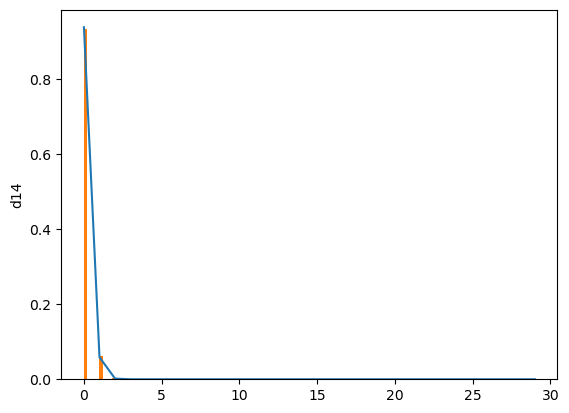

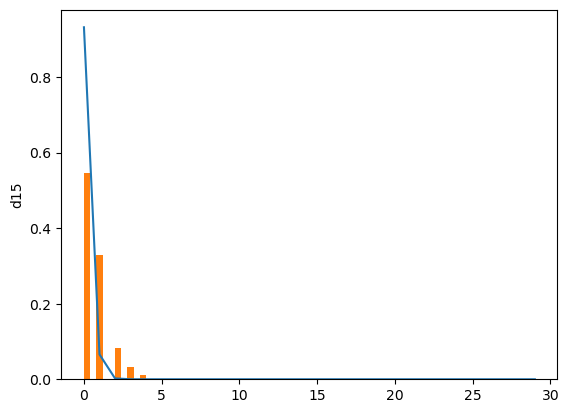

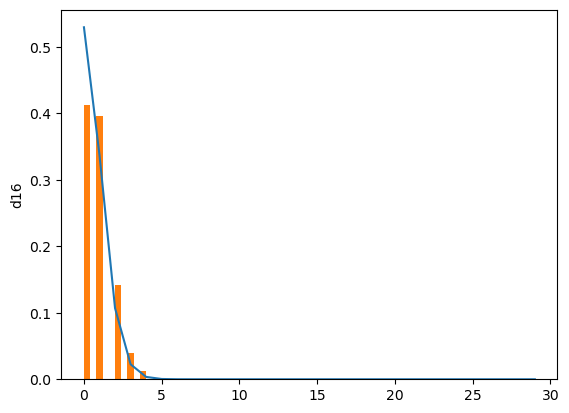

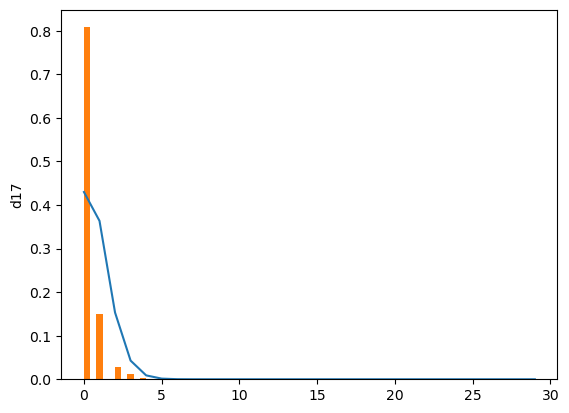

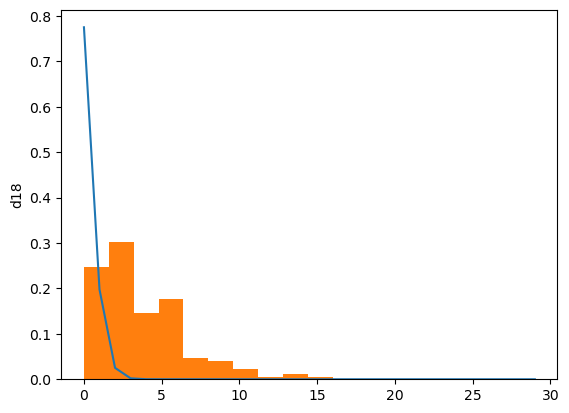

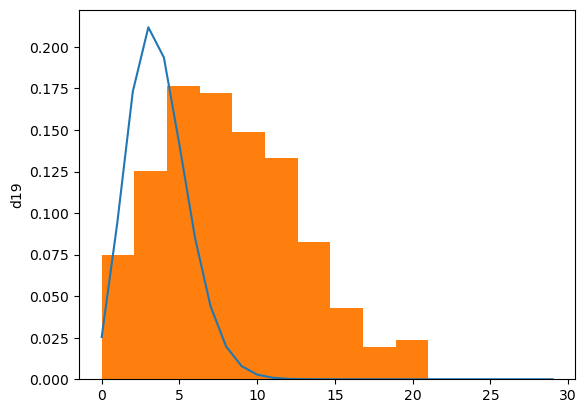

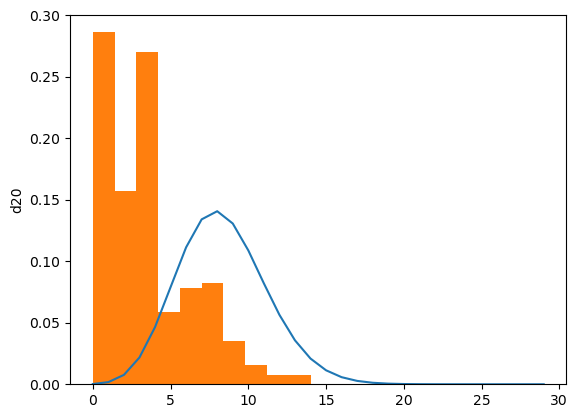

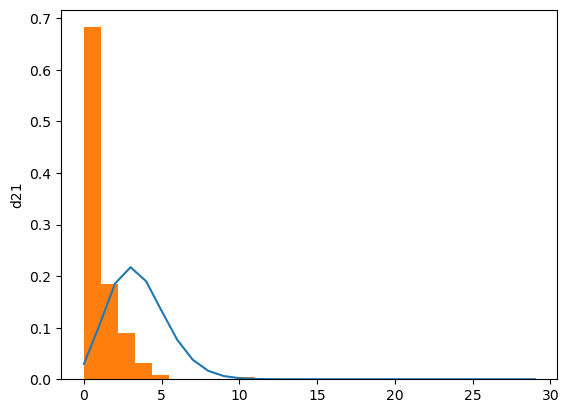

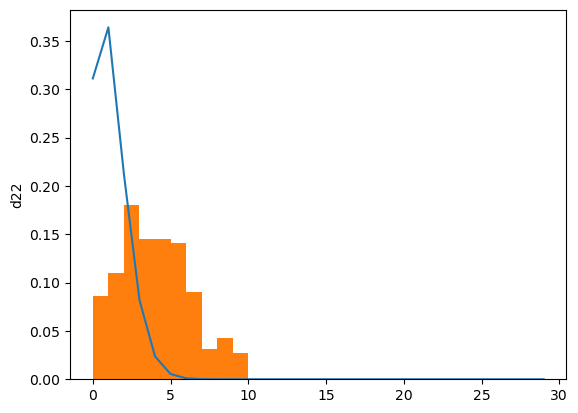

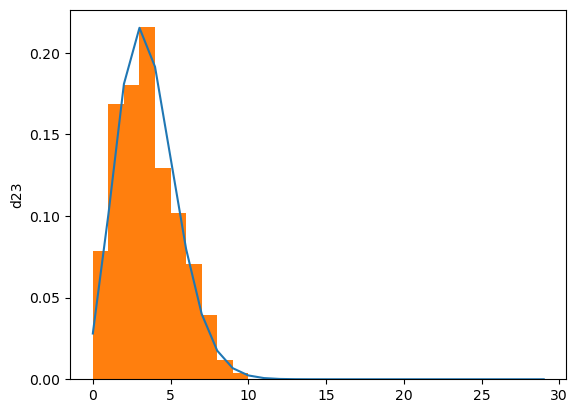

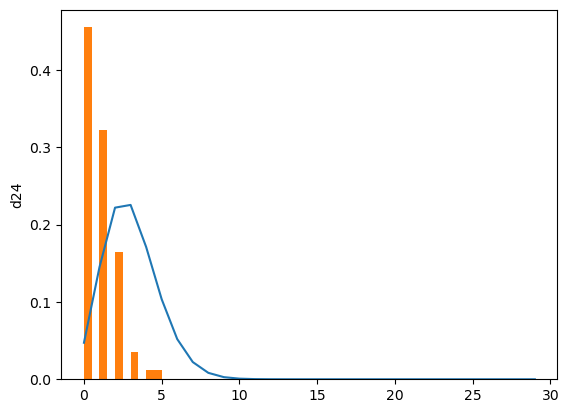

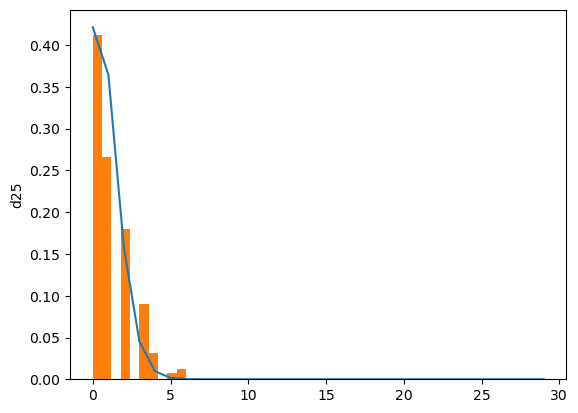

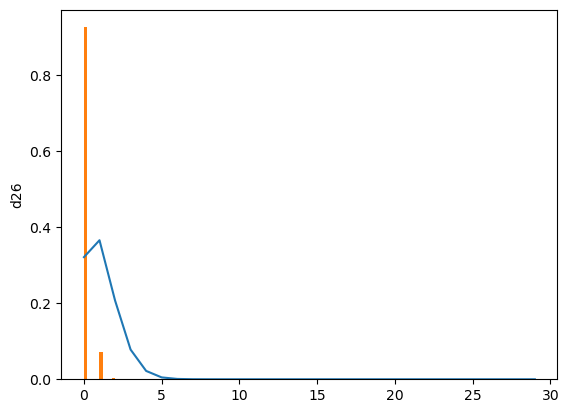

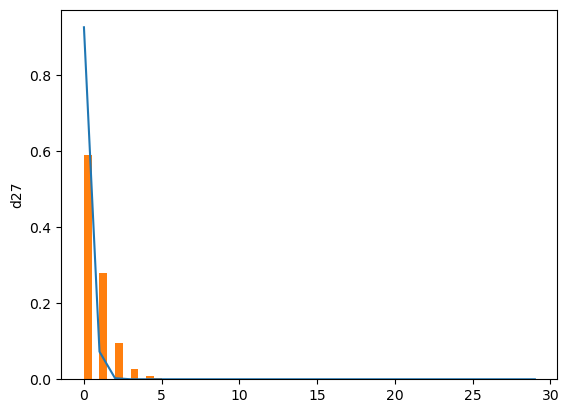

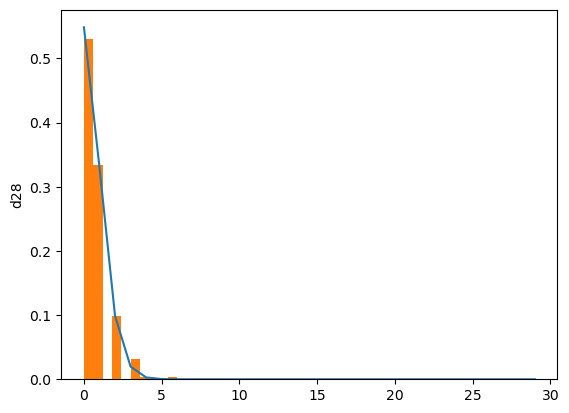

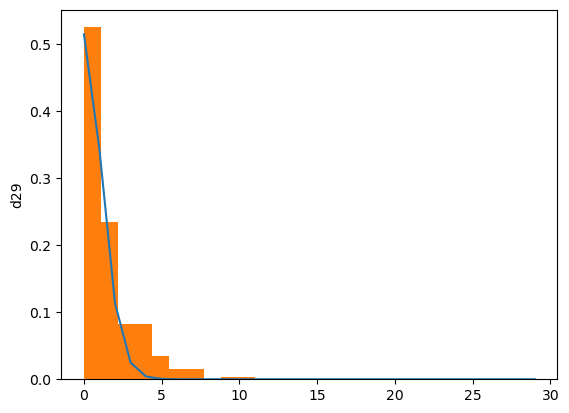

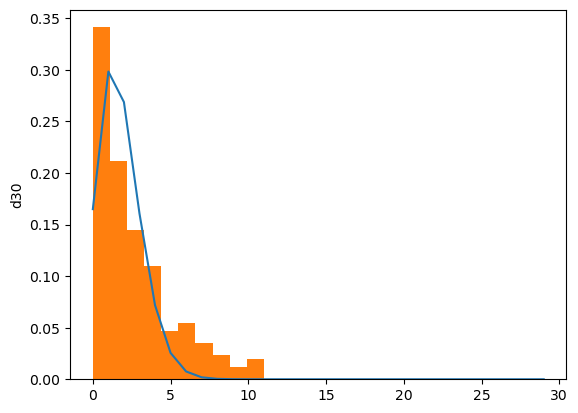

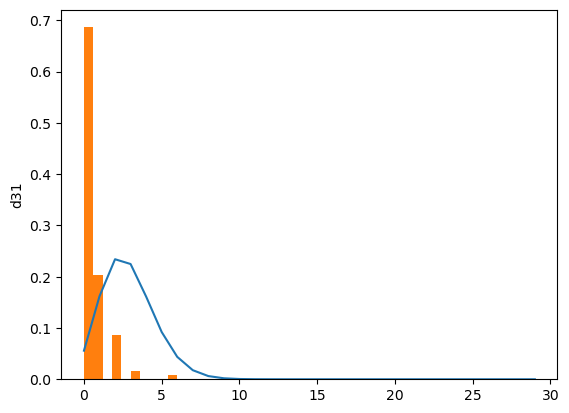

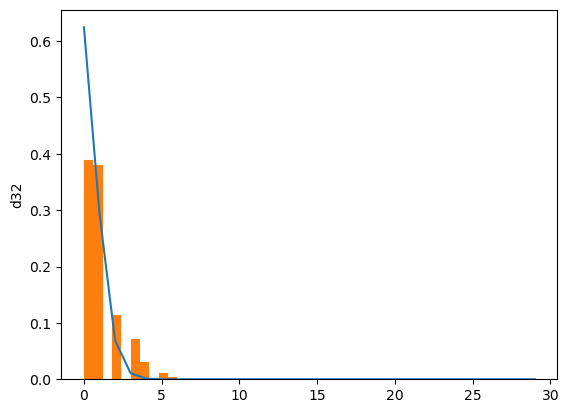

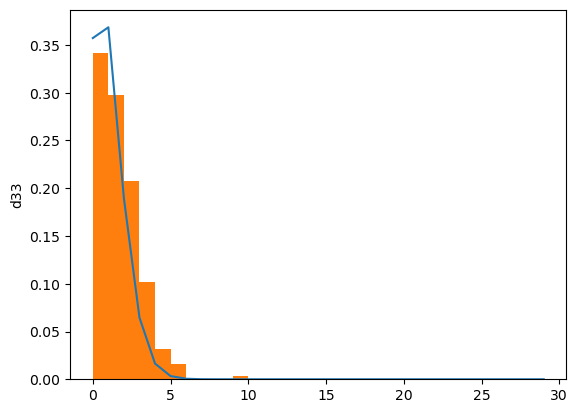

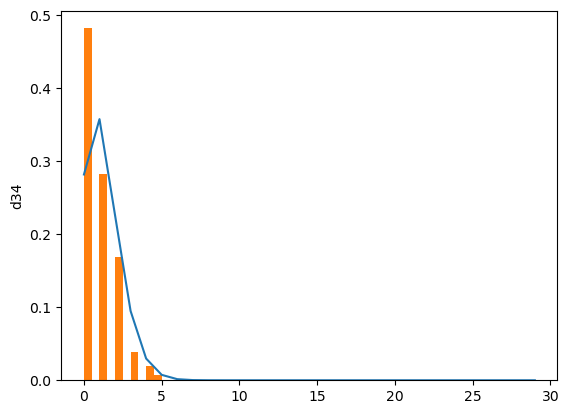

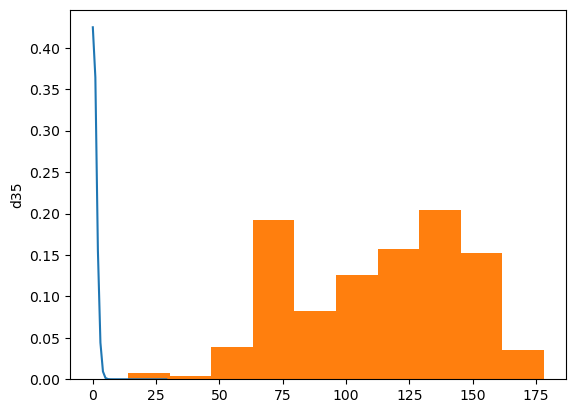

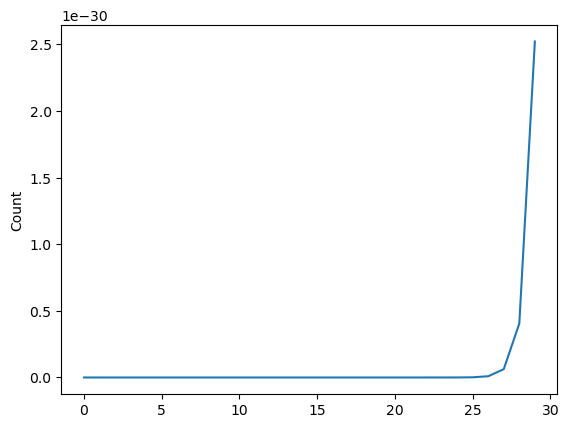

In [247]:
binplot2(data)

In [248]:
from scipy.stats import poisson

In [249]:
x0 = np.random.uniform()

In [250]:
def Xtplus1(Xt_1):
    return(Xt_1*np.random.uniform(low = 0.8, high = 1.2))

def Wt(Yt,Xt):
    return(poisson.pmf(Yt, mu=Xt))

Need to find dataframe that stipulates the probabilities!

In [251]:
probdata = pd.DataFrame()
cols = list(data)
cols = cols[:-2]
for ID in cols:
    probdata[ID] = data[ID]/data['Count']

We can now specify the pmf. i.e. Y - probdata[ID}.values

In [252]:
def multinomial_resample(weights):
    """ This is the naive form of roulette sampling where we compute the
    cumulative sum of the weights and then use binary search to select the
    resampled point based on a uniformly distributed random number. Run time
    is O(n log n). You do not want to use this algorithm in practice; for some
    reason it is popular in blogs and online courses so I included it for
    reference.
   Parameters
   ----------
    weights : list-like of float
        list of weights as floats
    Returns
    -------
    indexes : ndarray of ints
        array of indexes into the weights defining the resample. i.e. the
        index of the zeroth resample is indexes[0], etc.
    """
    cumulative_sum = np.cumsum(weights)
    #cumulative_sum[-1] = 1.  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, random(len(weights)))

In [253]:
import numpy as np
from numpy.random import random

def resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1  # avoid round-off errors: ensures sum is exactly one
    return np.searchsorted(cumulative_sum, np.random(len(weights)))

def Filter(X,Yobs,N):
    W = [0 for i in range(N)]
    #Draw
    for i in range(N):
        #Draw/Mutation
        X[i] = Xtplus1(X[i]) #unif
        #Compute weights
        W[i] = Wt(Yobs,X[i])

    #Normalise weights
    sumW = sum(W)
    for i in range(N):
        W[i] = W[i]/sumW
        
    #Resample from these weights    

    I = multinomial_resample(W)
    
    #Convert to state space vectors
    I = np.array(I)
    X = np.array(X)
    X = X[I]
    
    X_est = sum(X)/N
        
    return(X,X_est)    

In [254]:
np.random.choice([1,2,3,4], size=4, replace=True, p=W)

ValueError: 'a' and 'p' must have same size

X0 = [np.random.uniform() for i in range(0,100)]
W = [0 for i in range(len(X0))]
Y = data['d2'].values

In [ ]:
N = 100
X0 = [np.random.uniform() for i in range(0,100)]
xstart = X0
rate =np.zeros(len(Y))
X=X0
for i in range(0,len(Y)):
    [X,X_est] = Filter(X,Y[i],N)
    rate[i] = X_est

In [ ]:
def general_filter(Y,N,df,ID):
    d = np.array(df[ID])
    X0 = [np.mean(d) for i in range(0,N)]
    X = X0
    rate =np.zeros(len(Y))
    for i in range(0,len(Y)):
        [X,X_est] = Filter(X,Y[i],N)
        rate[i] = X_est
    return(rate)

In [60]:
#Draw values from initial distribution.
X0 = [np.random.uniform() for i in range(0,100)]
W = [0 for i in range(len(X0))]
Y = data['d2'].values
#Compute first weights
for i in range(0,len(X0)):
    W[i] = Wt(Y[0],X0[i])
for j in range(len(X0)):
    W[i] = W[i]/sum(W)


#for i in range(0,30):
#    X0,W = Filter(X0,W,Y)

In [89]:
general_filter(data['d1'],100)

TypeError: general_filter() missing 2 required positional arguments: 'df' and 'ID'

In [62]:
def Xtplus1(Xt_1):
    return(Xt_1*np.random.uniform(low = 0.8, high = 1.2))
    #return(Xt_1 *dnp.random.lognormal(mean=0.0, sigma=1.0)
    #return(Xt_1*np.random.exponential(scale = 1))
def Wt(Yt,Xt):
    return(poisson.pmf(Yt, mu=Xt))

In [100]:
def movingaveragemontecarlo(df,ID,K,N):
    p_est_dict = {}
    #changed plot to normal data
    vals = data[ID]
    df_dummy = df.copy()
    # p_est_array = np.array(Ksum(vals,K))/K
    rate = general_filter(df[ID],N,df,ID)
    
    #dfp.rolling(7, center=True).mean()
    hi = pd.DataFrame(vals)
    dude = pd.DataFrame(hi).rolling(K, center=True).mean()
    p_est_dict[ID] = dude[ID]
    p_est_array = dude[ID]
    
    hi = pd.DataFrame(df[ID])
    dude = pd.DataFrame(hi).rolling(K, center=True).mean()
    #return(d
    
    
    df_dummy['Plottingrate'] = rate
    
    figure(figsize=(10, 20), dpi=320)
    fig, ax = plt.subplots()
    #ax1.plot(df.index.values,df_dummy['Plottingrate'], color = 'red')
    #ax1.set_ylabel('SMC')
    
    #ax2 = ax1.twinx()
    #ax2.bar(df.index.values, dude[ID] ,width = 0.3)
    #ax2.set_ylabel('Moving Average')
    
    plt.plot(df.index.values,df_dummy['Plottingrate'], color = 'red')
    ax.bar(df.index.values, dude[ID] ,width = 0.3)
    
    #Ksum(df[ID].values,30)
    #
    #plt.plot(d0f.index.values, cumdata[ID])
    # ax1.plot(df.index.values,df_dummy['Plottingrate'], "r-")
    # ax1.ylabel('SMC')
    plt.title(ID)
    plt.savefig('new ' +ID+'.png')

<Figure size 3200x6400 with 0 Axes>

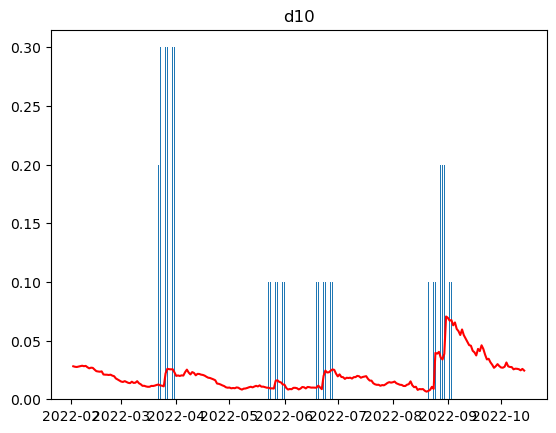

In [99]:
movingaveragemontecarlo(data,'d10',10,100)

Go through the documentaiton for this:
https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html 
Make sure that you are using the correct 

C:\Users\kianv\AppData\Local\Temp\ipykernel_18556\3830125349.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 20), dpi=320)


<Figure size 3200x6400 with 0 Axes>

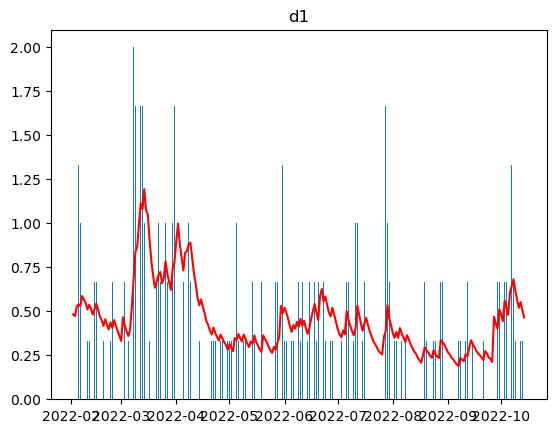

<Figure size 3200x6400 with 0 Axes>

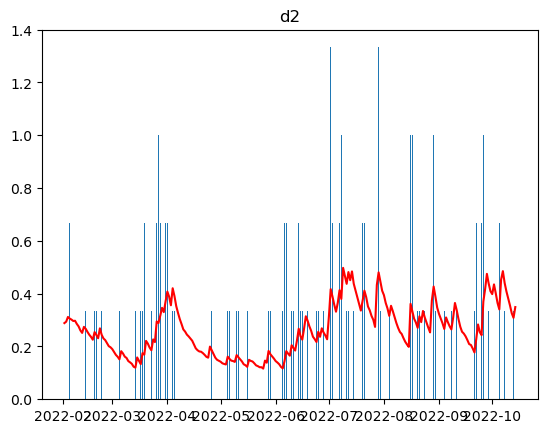

<Figure size 3200x6400 with 0 Axes>

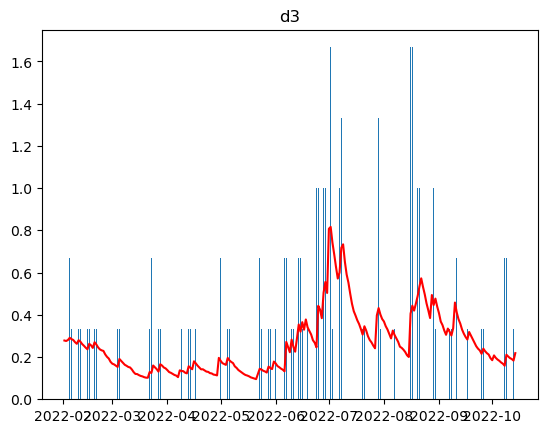

<Figure size 3200x6400 with 0 Axes>

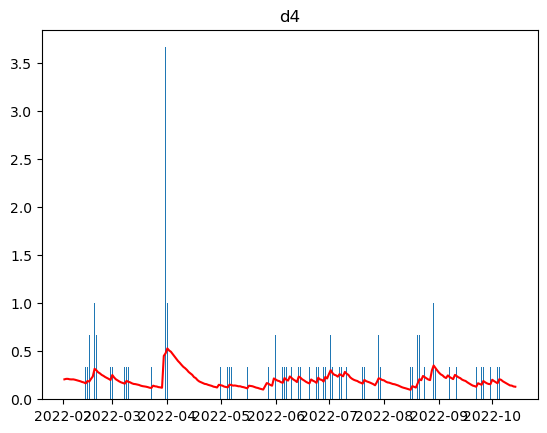

<Figure size 3200x6400 with 0 Axes>

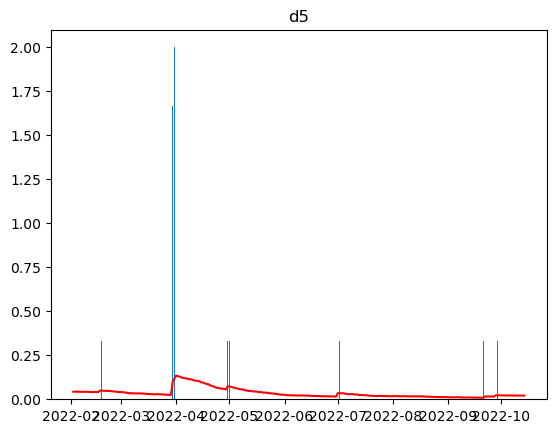

<Figure size 3200x6400 with 0 Axes>

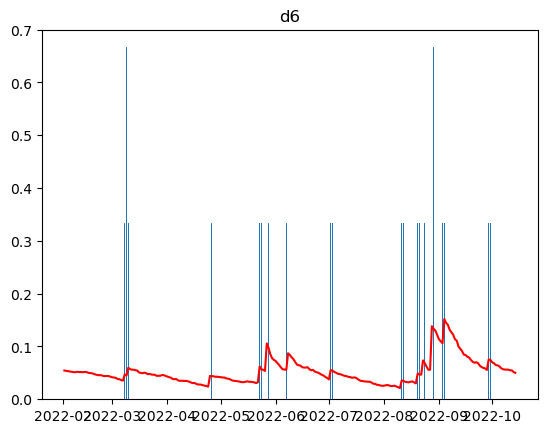

<Figure size 3200x6400 with 0 Axes>

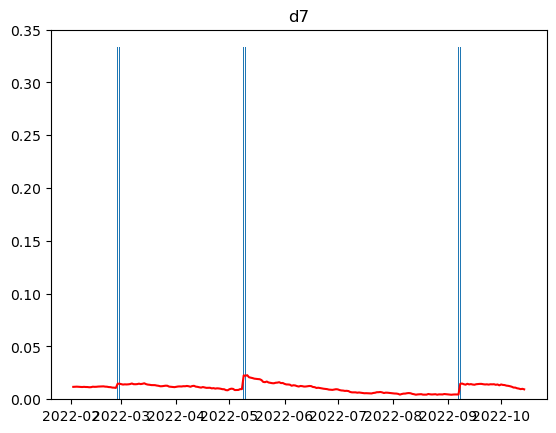

<Figure size 3200x6400 with 0 Axes>

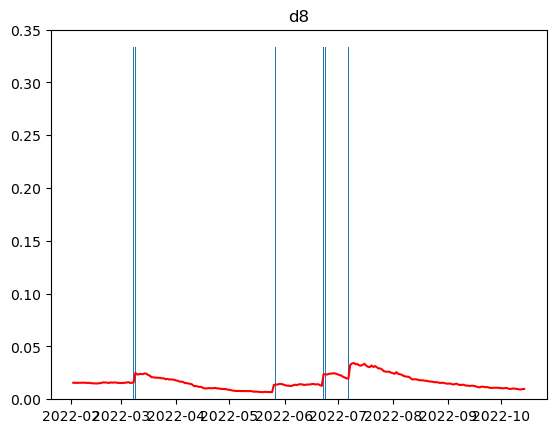

<Figure size 3200x6400 with 0 Axes>

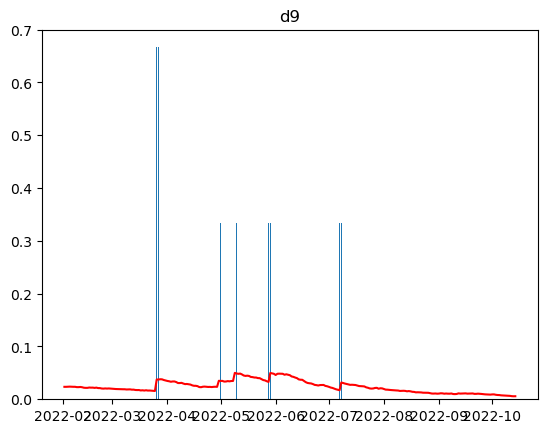

<Figure size 3200x6400 with 0 Axes>

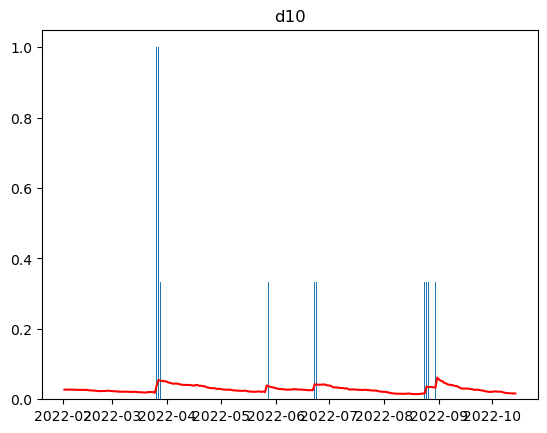

<Figure size 3200x6400 with 0 Axes>

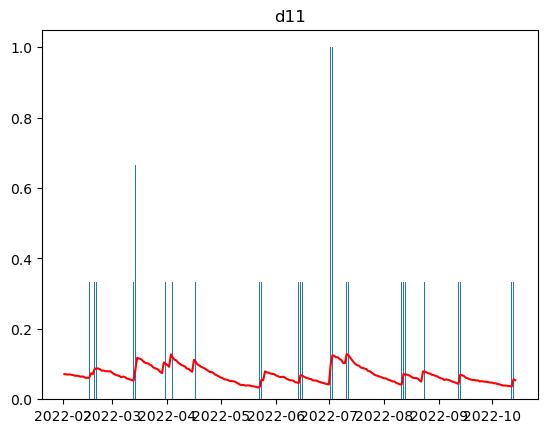

<Figure size 3200x6400 with 0 Axes>

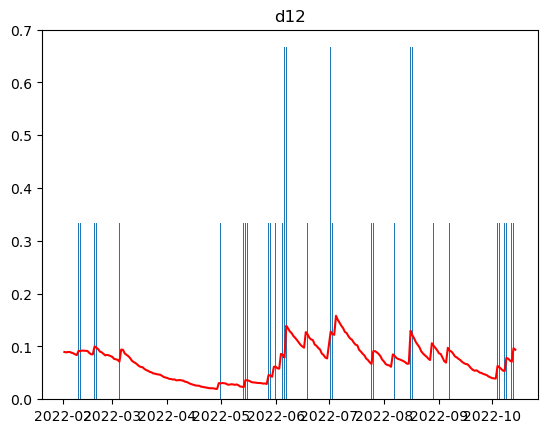

<Figure size 3200x6400 with 0 Axes>

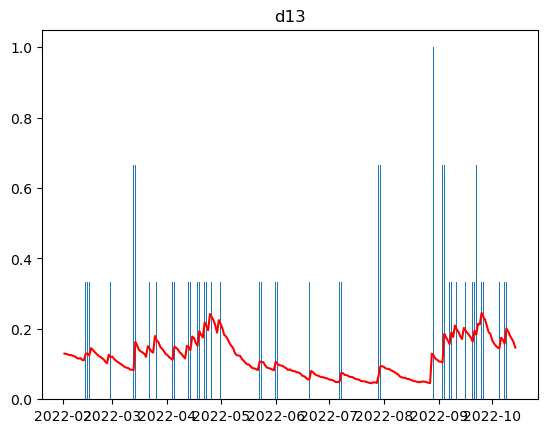

<Figure size 3200x6400 with 0 Axes>

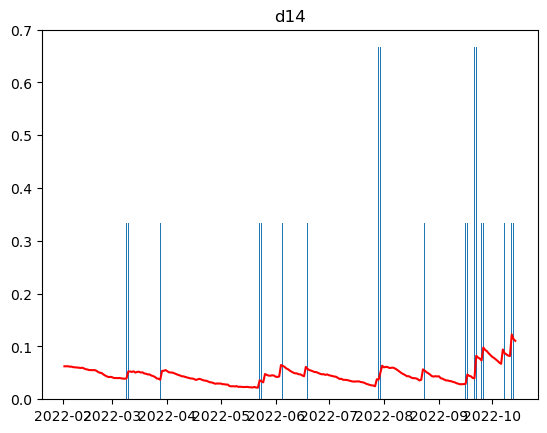

<Figure size 3200x6400 with 0 Axes>

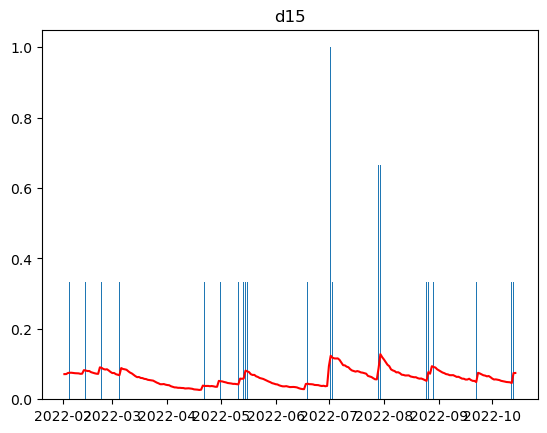

<Figure size 3200x6400 with 0 Axes>

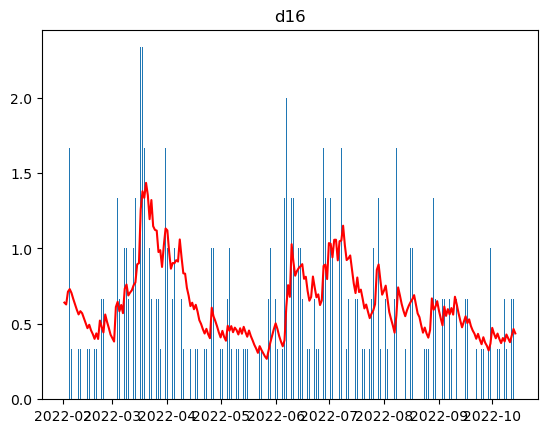

<Figure size 3200x6400 with 0 Axes>

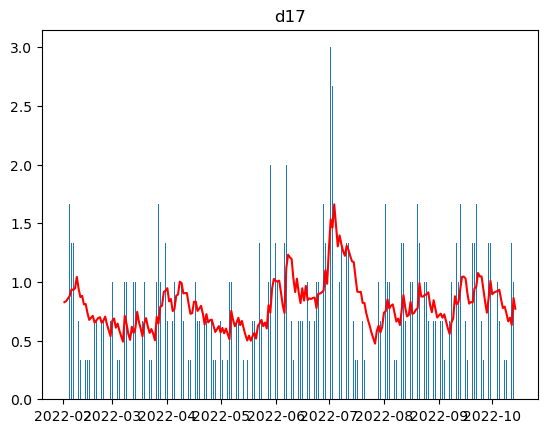

<Figure size 3200x6400 with 0 Axes>

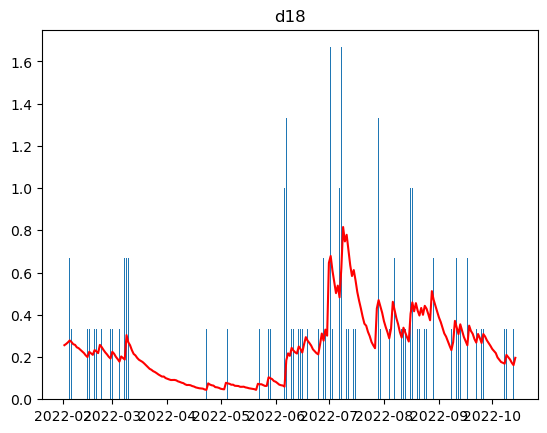

<Figure size 3200x6400 with 0 Axes>

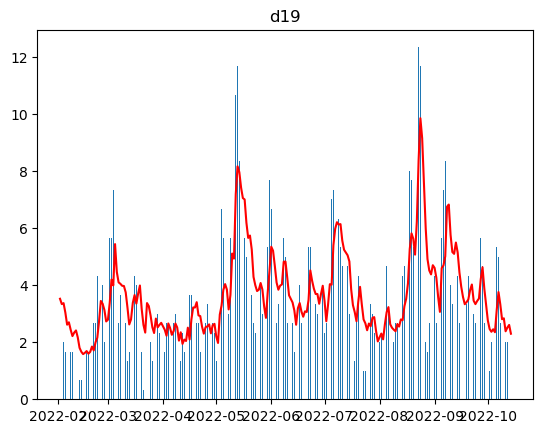

<Figure size 3200x6400 with 0 Axes>

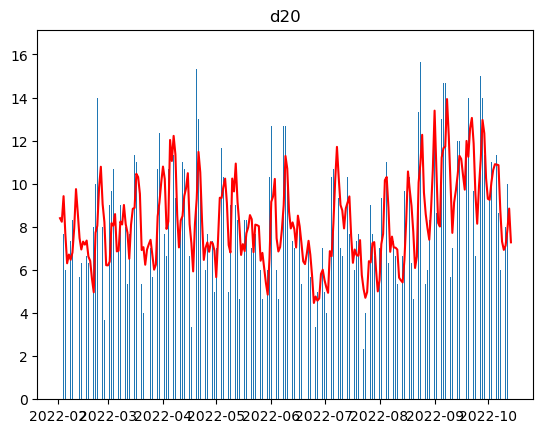

<Figure size 3200x6400 with 0 Axes>

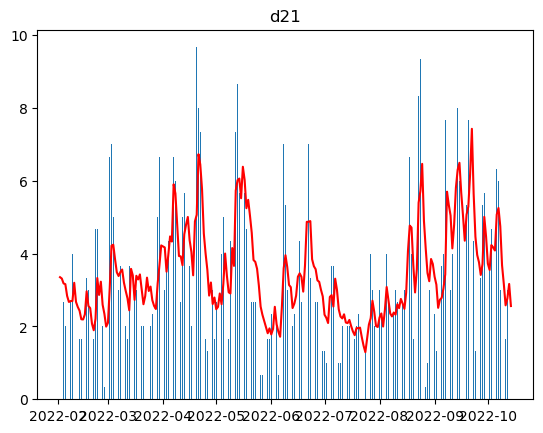

<Figure size 3200x6400 with 0 Axes>

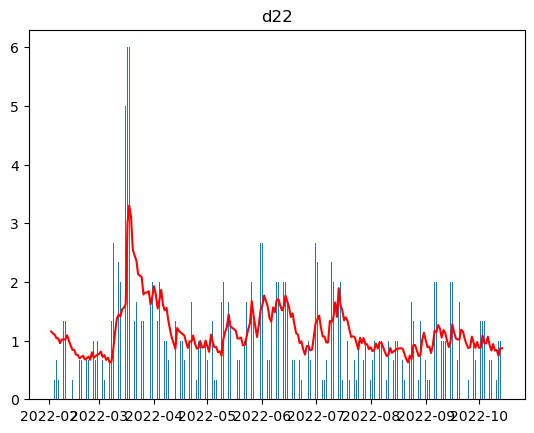

<Figure size 3200x6400 with 0 Axes>

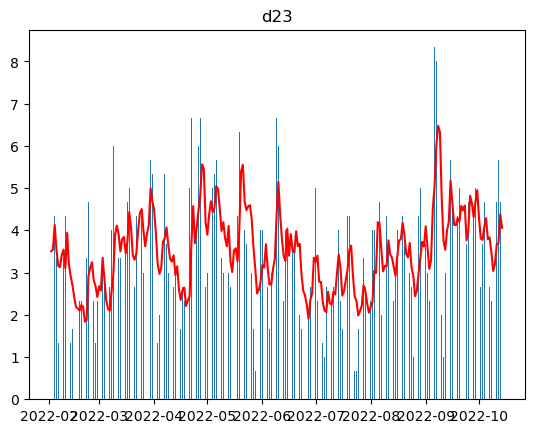

<Figure size 3200x6400 with 0 Axes>

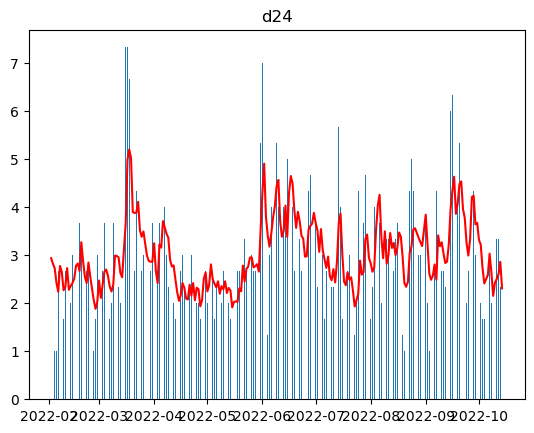

In [101]:
cols = list(data)
cols = cols[0:-2]
for ID in cols:
    movingaveragemontecarlo(data,ID,3,1000)